# Amazon, no supervisado

## Importar

In [1]:
# %load basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Diplomado/Amazon/data/'
os.listdir(liga)

['raw',
 'df_sentim.csv',
 'sentim.csv',
 'df.csv',
 'df_cluster.csv',
 'csv',
 'FitRec']

In [2]:
import time
start = time.time()

In [3]:
df = pd.read_csv(liga + 'df_sentim.csv')
df = df[df['Anio'] > 2009].copy()
#df = df.sample(frac = .2, random_state = 22).reset_index(drop = True)

print(len(df))
df.sample(2)

582156


,overall,verified,reviewTime,reviewText,summary,style,category,Anio,Mes,Sem,DiaSem,reviewText_limpio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound
178690,5.00,True,2014-01-17,This game very quickly became my favorite ente...,Best Mah Jong Version.,Sí,video_games,2014,ene,3,vie,game quickly became favorite entertainment com...,393.00,70.00,0.66,0.00,0.46,0.54,0.99
633544,5.00,True,2012-10-09,"is very nice, transparent, flexible, weighs no...",excellent product.,No_especifica,cell_phones_and_accessories,2012,oct,41,mar,nice transparent flexible weighs nothing usefu...,166.00,26.00,0.68,0.10,0.42,0.48,0.84


In [4]:
df.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewText              0
summary                 0
style                   0
category                0
Anio                    0
Mes                     0
Sem                     0
DiaSem                  0
reviewText_limpio      61
reviewText_long         0
reviewText_n_words      0
reviewText_relevant     0
neg                     0
neu                     0
pos                     0
compound                0
dtype: int64

In [5]:
df = df.dropna().drop(columns = ['reviewTime','reviewText','summary','Sem']).copy()
target = 'overall'

num = [x for x in df.describe().columns if x not in [target]]
cat = [x for x in df.columns if x not in num + ['reviewText_limpio',target]]
df = df[cat + num + ['reviewText_limpio',target]].copy()

print(len(df))
df.sample(4)

582095


,verified,style,category,Mes,DiaSem,Anio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound,reviewText_limpio,overall
1031,True,No_especifica,video_games,jul,lun,2013,161.00,34.00,0.54,0.00,0.65,0.35,0.77,used play game time kid recently came n get ga...,5.00
79141,True,No_especifica,video_games,jun,jue,2011,119.00,23.00,0.52,0.00,0.60,0.40,0.65,finally able afford game kid love matter final...,4.00
284240,True,No_especifica,kindle_store,abr,mie,2017,26.00,5.00,0.78,0.00,0.51,0.49,0.44,good story five star,5.00
333543,True,No_especifica,kindle_store,oct,jue,2014,701.00,130.00,0.66,0.11,0.57,0.32,0.95,received book free author honest review recall...,4.00


## Funciones

In [6]:
def outlier(df, x, p = 0.22):
    var = df[x]
    q1 = var.quantile(p/2)
    q3 = var.quantile(1 - p/2)
    iqr = q3 - q1
    df = df[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))].copy()
    return df

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def text_vectorizer(df, 
                    texto, 
                    cv = True,
                    tv = True,
                    n_gram = (1,1),
                    max_features = 100):
    
    params = {'ngram_range' : n_gram, 
              'min_df' : 1, 
              'max_features' : max_features}    
    if cv:
        cv = CountVectorizer(**params)
        df = df.join(pd.DataFrame(data = cv.fit_transform(df[texto]).todense(),
                                  columns = [x+"_cv" for x in cv.get_feature_names()]))
    if tv:
        tv = TfidfVectorizer(**params)
        df = df.join(pd.DataFrame(data = tv.fit_transform(df[texto]).todense(),
                                  columns = [x+"_tv" for x in tv.get_feature_names()]))
    return df, [x+"_cv" for x in cv.get_feature_names()], [x+"_cv" for x in cv.get_feature_names()]

In [8]:
import math
def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

## TAD

In [9]:
dim_antes = len(df)
for col in num:
    df = outlier(df,col)
    
df.reset_index(drop = True, inplace = True)
print(len(df) / dim_antes)

0.9539868921739578


In [10]:
df, words_cv, words_tv = text_vectorizer(df,'reviewText_limpio', max_features = 22)
df.drop(columns = ['reviewText_limpio'], inplace = True)
df.sample(4)

,verified,style,category,Mes,DiaSem,Anio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound,overall,book_cv,case_cv,character_cv,five_cv,game_cv,get_cv,good_cv,great_cv,like_cv,love_cv,movie_cv,much_cv,one_cv,phone_cv,read_cv,really_cv,star_cv,story_cv,time_cv,well_cv,work_cv,would_cv,book_tv,case_tv,character_tv,five_tv,game_tv,get_tv,good_tv,great_tv,like_tv,love_tv,movie_tv,much_tv,one_tv,phone_tv,read_tv,really_tv,star_tv,story_tv,time_tv,well_tv,work_tv,would_tv
51742,False,No_especifica,video_games,jul,mar,2014,225.00,43.00,0.57,0.14,0.39,0.47,0.85,1.00,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.57,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
397431,True,No_especifica,cell_phones_and_accessories,jul,vie,2014,725.00,129.00,0.66,0.07,0.72,0.21,0.90,1.00,0,0,0,0,0,0,0,2,0,0,0,0,0,4,0,0,0,0,0,0,2,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.85,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00
17881,True,Sí,video_games,mar,lun,2014,112.00,25.00,0.68,0.14,0.72,0.14,0.02,2.00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,0.63,0.00
157838,True,No_especifica,kindle_store,sep,jue,2013,479.00,93.00,0.57,0.16,0.52,0.32,0.76,3.00,3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.30


## Modelado

### Preprocesamiento

In [11]:
X = df[cat + num].copy()
y = df[target].values
X.describe()

,Anio,reviewText_long,reviewText_n_words,reviewText_relevant,neg,neu,pos,compound
count,555311.00,555311.00,555311.00,555311.00,555311.00,555311.00,555311.00,555311.00
mean,2013.73,305.45,56.40,0.66,0.06,0.54,0.40,0.65
std,1.65,345.80,62.64,0.12,0.09,0.18,0.20,0.42
min,2010.00,5.00,2.00,0.08,0.00,0.00,0.00,-1.00
25%,2013.00,93.00,17.00,0.57,0.00,0.42,0.27,0.51
50%,2014.00,180.00,34.00,0.63,0.00,0.53,0.40,0.83
75%,2015.00,374.00,70.00,0.71,0.10,0.64,0.54,0.94
max,2018.00,2214.00,340.00,1.00,0.46,1.00,1.00,1.00


In [12]:
#Encoder para categóricas
from category_encoders.cat_boost import CatBoostEncoder
encod = CatBoostEncoder()

#Escala para numéricas
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler()

#Se aplicará transformación para cada tipo de columnas
from sklearn.compose import ColumnTransformer
prep = ColumnTransformer(transformers=[('OHE', encod, cat),
                                       ('Scale', mm_x, num)])

Xs = pd.DataFrame(prep.fit_transform(X,y), index = df.index)

Xs.sample(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12
243224,False,4.24,4.22,4.26,4.27,0.50,0.11,0.12,0.62,0.00,0.56,0.44,0.96
104403,True,4.26,4.17,4.35,4.33,0.50,0.11,0.13,0.55,0.13,0.36,0.58,0.98
7979,True,4.54,4.56,4.56,4.57,0.00,0.18,0.22,0.54,0.46,0.56,0.23,0.74
212364,True,4.23,4.20,4.28,4.27,0.25,0.13,0.16,0.62,0.17,0.45,0.47,0.97


### Entrenamiento

In [13]:
import string
from sklearn.cluster import KMeans
n_clusters = 4
cluster = KMeans(n_clusters = n_clusters, random_state = 22)

dict_cluster = dict(zip(range(n_clusters),string.ascii_uppercase[:n_clusters]))
Xs['Cluster'] = X['Cluster'] = df['Cluster'] = pd.DataFrame(cluster.fit_predict(Xs)).replace(dict_cluster)

df['Cluster'].value_counts(1).reset_index().set_index('index')

,Cluster
index,
B,0.37
D,0.35
C,0.14
A,0.14


### PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
Xp = pd.DataFrame(pca.fit_transform(Xs.iloc[:,:-1]), index = Xs.index, columns=['p1', 'p2'])

Xp['Cluster'] = Xs['Cluster'].astype(str)
pca.explained_variance_ratio_.cumsum()

array([0.31867591, 0.53148778])

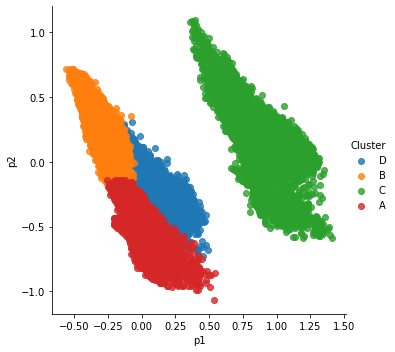

In [15]:
import seaborn as sns
sns.lmplot(data = Xp.sample(frac = .1),
           x = 'p1',
           y = 'p2',
           fit_reg = False, 
           hue = 'Cluster')

In [16]:
df[num + ['Cluster']].groupby('Cluster')[num].mean().transpose()

Cluster,A,B,C,D
Anio,2014.12,2014.69,2013.04,2012.84
reviewText_long,227.25,107.51,547.98,444.21
reviewText_n_words,42.13,19.95,99.56,82.53
reviewText_relevant,0.65,0.72,0.64,0.60
neg,0.15,0.02,0.08,0.06
neu,0.74,0.41,0.56,0.59
pos,0.12,0.57,0.35,0.35
compound,-0.12,0.76,0.66,0.83


In [17]:
df[cat + ['Cluster']].groupby('Cluster')[cat].agg({lambda x:x.value_counts().index[0]})

,verified,style,category,Mes,DiaSem
,<lambda>,<lambda>,<lambda>,<lambda>,<lambda>
Cluster,,,,,
A,True,No_especifica,cell_phones_and_accessories,ene,lun
B,True,No_especifica,movies_and_tv,ene,lun
C,False,No_especifica,kindle_store,ago,lun
D,True,No_especifica,kindle_store,dic,lun


## Fin

In [18]:
#Exportar modelo
import pickle
with open('modelo_cluster_amazon.pkl', "wb") as f:
    pickle.dump(cluster, f)
    
#Exportar DF
df.to_csv(liga + 'df_cluster.csv', index = False)

In [19]:
#Importar modelo
import pickle    
with open('modelo_cluster_amazon.pkl', "rb") as f:
    modelo = pickle.load(f)
    
modelo

KMeans(n_clusters=4, random_state=22)

In [20]:
#Tiempo total para correr el notebook
end = time.time()
time_exp(end - start)

2 minutos con 20.00 segundos


In [21]:
#Tono para cuando termina el script
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(5*np.pi*300*t) + np.sin(2*np.pi*240*t)

#La siguiente línea suena!
Audio(audio_data, rate=framerate, autoplay=True)